In [1]:
import sys

sys.path.append('..')

!pip install -q dask-ml

In [2]:
import os
import gc
import yaml
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import joblib

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [3]:
BASE_PATH = '../../'

CONFIG_DIR = os.path.join(BASE_PATH, 'config')
STORAGE_DIR = os.path.join(BASE_PATH, 'storage')

config = yaml.load(open(os.path.join(CONFIG_DIR, 'env.yml')),
                   Loader=yaml.FullLoader)

In [4]:
output_storage = os.path.join(STORAGE_DIR, 'output')

In [5]:
features = ['battery_level', 'timezone',
       'memory_active', 'memory_inactive', 'memory_free', 'memory_user',
       'health', 'voltage', 'temperature', 'usage', 'up_time', 'sleep_time',
       'wifi_signal_strength', 'wifi_link_speed', 'screen_on',
       'screen_brightness', 'roaming_enabled', 'bluetooth_enabled',
       'location_enabled', 'power_saver_enabled', 'nfc_enabled',
       'developer_mode', 'free', 'total', 'free_system', 'total_system',
       'wifi_enabled', 'mobile_enabled', 'wifi_active', 'mobile_active',
       'profile', 'time_diff', 'prev_level']

In [6]:
df = pd.read_parquet(os.path.join(output_storage, 'unplugged.parquet'), columns=features)

In [7]:
string_columns = df[features].select_dtypes(include='object').columns.to_list()
binary_columns = df[features].select_dtypes(include='bool').columns.to_list()

In [8]:
df[string_columns] = df[string_columns].astype('category')
for column in string_columns:
    df.loc[:, column] = df[column].cat.codes

In [9]:
df[binary_columns] = df[binary_columns].astype(np.uint8)

In [10]:
df.head()

,battery_level,timezone,memory_active,memory_inactive,memory_free,memory_user,health,voltage,temperature,usage,...,total,free_system,total_system,wifi_enabled,mobile_enabled,wifi_active,mobile_active,profile,time_diff,prev_level
0,61,244,1058492,1065028,2901828,58924,1,3.87,32.3,80,...,26993,24,2299,0,1,0,1,1281,122.0,62.0
1,60,244,1045868,1043208,2901828,56900,1,3.79,31.8,78,...,26993,24,2299,0,1,0,1,1281,367.0,61.0
2,59,244,1022756,1032260,2901828,91880,1,3.81,31.8,66,...,26993,24,2299,0,1,0,1,1281,92.0,60.0
3,58,244,1017528,1017440,2901828,57960,1,3.74,31.7,68,...,26993,24,2299,0,1,0,1,1281,150.0,59.0
4,57,244,994532,1001584,2901828,98360,1,3.77,31.7,94,...,26993,24,2299,0,1,0,1,1281,100.0,58.0


In [11]:
df['time_diff'].describe()

count    1.078372e+07
mean     2.168244e+02
std      2.517740e+02
min      1.900000e+01
25%      7.000000e+01
50%      1.340000e+02
75%      2.400000e+02
max      1.577000e+03
Name: time_diff, dtype: float64

In [12]:
from scipy.stats import zscore

z_scores = np.abs(df[['time_diff']].apply(zscore, raw=True))

df = df[(z_scores <= 3).all(axis=1)]

In [13]:
# df = df.head(df.shape[0] * 50 // 100)
df = df.sample(frac=0.5, random_state=0)

In [ ]:
df['time_diff'].hist()

In [14]:
X = df.drop('time_diff', axis=1)
y = df['time_diff']

In [15]:
del df
gc.collect()

66

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
del X
del y
gc.collect()

44

## Linear Regression

In [18]:
model = make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1))

In [19]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression(n_jobs=-1))])

In [20]:
model.score(X_test, y_test)

0.1558689093897222

In [21]:
y_pred = model.predict(X_test)

In [22]:
mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)

(109.68953772276828, 25212.432430067078)

## Ridge regression

In [23]:
model = make_pipeline(StandardScaler(), Ridge(random_state=0))

In [24]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(random_state=0))])

In [25]:
model.score(X_test, y_test)

0.15587036229848716

In [26]:
y_pred = model.predict(X_test)

In [27]:
mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)

(109.68995664781629, 25212.389034717147)

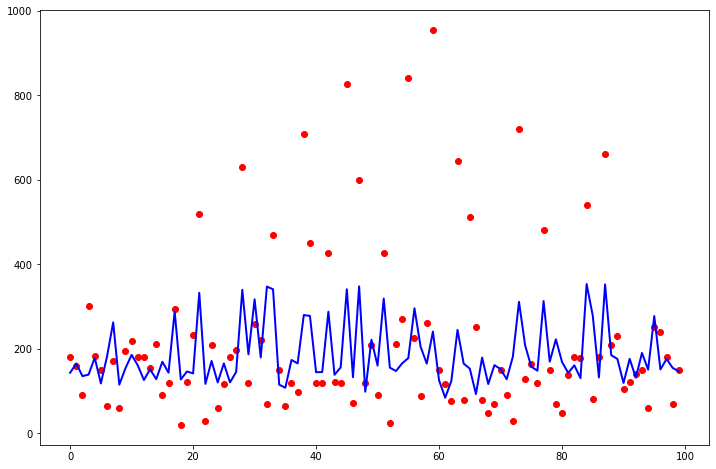

In [29]:
plt.figure(figsize=(12,8))
plt.scatter(range(0, 100), y_test[:100],  color='red')
plt.plot(range(0, 100), y_pred[:100], color='blue', linewidth=2)

plt.show()

## Elastic Net

In [30]:
from sklearn.linear_model import ElasticNet

model = make_pipeline(StandardScaler(), ElasticNet(random_state=0))

In [31]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet(random_state=0))])

In [32]:
model.score(X_test, y_test)

0.13419310813432195

In [33]:
y_pred = model.predict(X_test)

In [34]:
mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)

(111.7811389989423, 25859.84333649897)

## Lasso Regression

In [35]:
from sklearn.linear_model import Lasso

model = make_pipeline(StandardScaler(), Lasso(random_state=0))

In [36]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(random_state=0))])

In [37]:
model.score(X_test, y_test)

0.14912767789242853

In [38]:
y_pred = model.predict(X_test)

In [39]:
mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)

(110.23959417240087, 25413.778933603728)